# 3-1,低阶API示范

下面的范例使用Pytorch的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)



In [2]:
import torch 
print("torch.__version__="+torch.__version__) 

torch.__version__=2.4.0


### 一，线性回归模型

**1，准备数据**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn


#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动




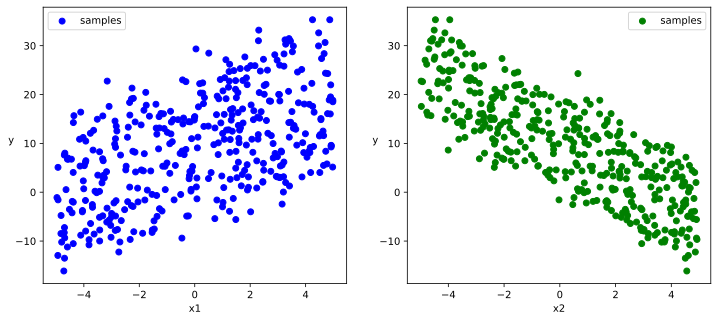

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()



In [5]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)



tensor([[ 1.3548, -0.6212],
        [-0.8983,  1.6796],
        [-2.8878, -2.3437],
        [ 1.6796,  4.3766],
        [ 2.7618,  1.2813],
        [ 2.0166,  4.7269],
        [ 1.5738,  1.8462],
        [-3.4331, -1.5349]])
tensor([[12.4911],
        [ 3.8689],
        [ 9.8505],
        [ 1.3075],
        [11.5907],
        [-4.0120],
        [ 6.1441],
        [ 8.2779]])


**2，定义模型**

In [6]:
# 定义模型
class LinearRegression: 
    
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)
        
    #正向传播
    def forward(self,x): 
        return x@self.w + self.b

    # 损失函数
    def loss_fn(self,y_pred,y_true):  
        return torch.mean((y_pred - y_true)**2/2)

model = LinearRegression()


**3，训练模型**

In [7]:
def train_step(model, features, labels):
    
    predictions = model.forward(features)
    loss = model.loss_fn(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad

        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss
 
    
    

In [8]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)


tensor(290.5953, grad_fn=<MeanBackward0>)

In [9]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%20==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)

train_model(model,epochs = 200)



================================================================================2024-09-11 11:31:11
epoch = 20 loss =  9.318801879882812
model.w = tensor([[ 2.1358],
        [-2.8515]])
model.b = tensor([[5.4055]])

================================================================================2024-09-11 11:31:11
epoch = 40 loss =  3.9173941612243652
model.w = tensor([[ 2.0941],
        [-2.9529]])
model.b = tensor([[7.8881]])

================================================================================2024-09-11 11:31:11
epoch = 60 loss =  0.7973614931106567
model.w = tensor([[ 2.0696],
        [-2.9900]])
model.b = tensor([[9.0147]])

================================================================================2024-09-11 11:31:11
epoch = 80 loss =  2.123945951461792
model.w = tensor([[ 2.0592],
        [-3.0097]])
model.b = tensor([[9.5262]])

================================================================================2024-09-11 11:31:11
epoch = 100 loss =  1.53015637397

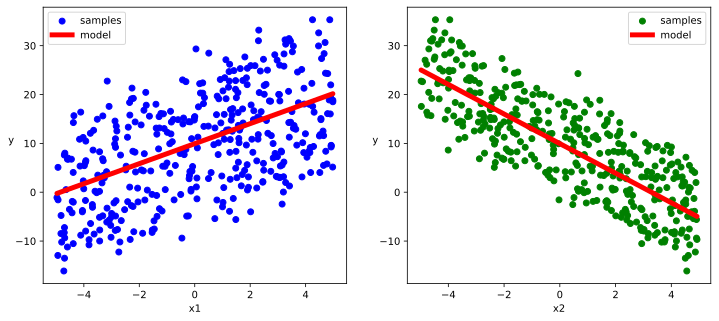

In [10]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


### 二，DNN二分类模型

**1，准备数据**

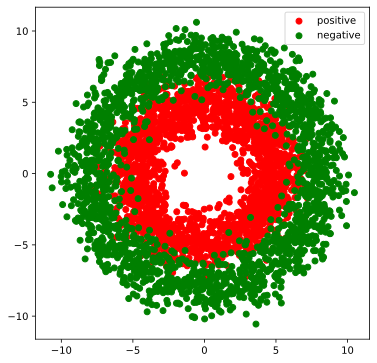

In [11]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


In [12]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)


tensor([[-6.0515,  4.7644],
        [ 6.6565,  0.4222],
        [-6.1227, -3.6599],
        [ 6.3891,  2.9593],
        [ 5.8660,  0.8376],
        [ 4.2341,  7.2450],
        [ 4.1550, -5.0158],
        [-4.6926,  1.2011]])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])


**2，定义模型**

此处范例我们利用nn.Module来组织模型变量。

In [13]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))

    # 正向传播
    def forward(self,x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    def loss_fn(self,y_pred,y_true):  
        #将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred,eps,1.0-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    
    # 评估指标(准确率)
    def metric_fn(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
model = DNNModel()


In [14]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_fn(labels,predictions)
metric = model.metric_fn(labels,predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())


init loss: 8.678373336791992
init metric: 0.45674362778663635


In [15]:
len(list(model.parameters()))

6

**3，训练模型**

In [16]:
def train_step(model, features, labels):   
    
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_fn(predictions,labels)
    metric = model.metric_fn(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降法更新参数
    for param in model.parameters():
        #注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        param.data = (param.data - 0.01*param.grad.data) 
        
    # 梯度清零
    model.zero_grad()
        
    return loss.item(),metric.item()
 

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in data_iter(X,Y,20):
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%10==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 100)



================================================================================2024-09-11 11:31:30
epoch = 10 loss =  0.6178725206851959 metric =  0.6392499993741513

================================================================================2024-09-11 11:31:30
epoch = 20 loss =  0.5076748777925968 metric =  0.784750000834465

================================================================================2024-09-11 11:31:30
epoch = 30 loss =  0.3264979888498783 metric =  0.8867499965429306

================================================================================2024-09-11 11:31:30
epoch = 40 loss =  0.20330130569636823 metric =  0.9174999931454658

================================================================================2024-09-11 11:31:31
epoch = 50 loss =  0.19612594677135348 metric =  0.9157499933242798

================================================================================2024-09-11 11:31:31
epoch = 60 loss =  0.19722926523536444 metric =  0.9164999

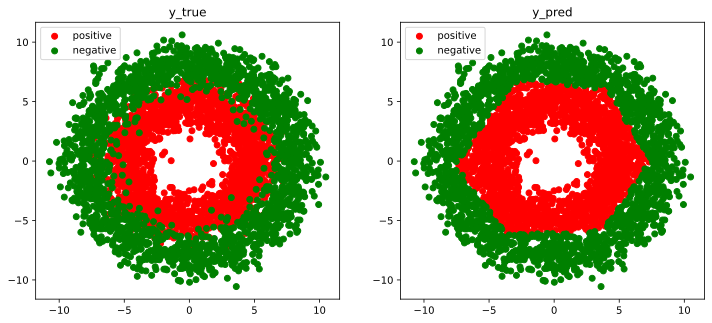

In [17]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)